In [13]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import random

np.random.seed(1234)
random.seed(1234)


routing_algorithm = ["RoundRobin-LCLB", "RoundRobin-MCLB", "RoundRobin-heuristic_TE"]
cluster_id = [0, 1]

marker_list = ['d', 'o', 'x', 'v', '^', '<', '>', 's', '8', 'p']
color_list = [ "purple","orange", "green", "brown", "cyan", "#C20078", "#FAC205", "gray","#FBDD7E", "#06C2AC", "#FFFF14", "#E6DAA6","olive", "#76FF7B", "pink", "#BC8F6", "#AAA662"]

blue_color = ['#0F52BA', '#6593F5', '#73C2FB']
green_color = ['#008000', '#50C878', '#90EE90']


def calc_resource_usage(files):
    assert len(routing_algorithm) == len(files)
    df_list = list()
    for i in range(len(routing_algorithm)):
        routing = routing_algorithm[i]
        df = pd.read_csv(files[i])
        df["routing"] = [routing]*len(df) # add new column
        df_list.append(df)
    df = pd.concat(df_list, axis=0)
    df = df.reset_index(drop=True)
    # display(df)
    # print(len(df))
    
    df_usage = pd.DataFrame(columns=["service", "cluster_id", "routing", "num_replica", "capacity"])
    svc_list = df["service"].unique()
    for cid in cluster_id:
        for routing in routing_algorithm:
            for svc in svc_list:
                temp_df = df[df["routing"] == routing]
                temp_df = temp_df[temp_df["service"] == svc]
                temp_df = temp_df[temp_df["cluster_id"] == cid]
                temp_df = temp_df.reset_index(drop=True)
                capa = 0
                num_repl = 0
                for i in range(len(temp_df)-1):
                    temp_df.loc[i, "timestamp"]
                    duration = (temp_df.loc[i+1, "timestamp"] - temp_df.loc[i, "timestamp"])
                    num_repl += duration * temp_df.loc[i,"num_replica"]
                    capa += duration * temp_df.loc[i,"capacity"]
                df_usage.loc[len(df_usage)] = [svc, cid, routing, num_repl, capa]
    df_usage = df_usage.sort_values(by=["service", "cluster_id", "routing"])
    df_usage = df_usage.reset_index(drop=True)
    num_repl_norm_list = list()
    capa_norm_list = list()
    for svc in svc_list:
        temp_df = df_usage[df_usage["cluster_id"]==0]
        temp_df = temp_df[temp_df["service"]==svc]
        temp_df = temp_df[temp_df["routing"]==routing_algorithm[0]]
        lclb_num_repl = float(temp_df["num_replica"])
        lclb_capa = float(temp_df["capacity"])
        num = len(cluster_id)*len(routing_algorithm)
        for _ in range(num):
            num_repl_norm_list.append(lclb_num_repl)
            capa_norm_list.append(lclb_capa)
    assert len(num_repl_norm_list) == len(df_usage)
    assert len(capa_norm_list) == len(df_usage)
    normalized_num_replica = list()
    normalized_capa= list()

    # print("num_repl_norm_list")
    # for i in range(len(num_repl_norm_list)):
    #     if (i+1)%3 == 0:
    #         print(num_repl_norm_list[i])
    #     else:
    #         print(num_repl_norm_list[i], end=", ")

    for i in range(len(df_usage)):
        nnrepl = df_usage.loc[i,"num_replica"]/num_repl_norm_list[i]
        ncapa = df_usage.loc[i,"capacity"]/capa_norm_list[i]
        normalized_num_replica.append(nnrepl)
        normalized_capa.append(ncapa)
    df_usage["norm_num_replica"] = normalized_num_replica
    df_usage["norm_capacity"] = normalized_capa
    # display(df_usage)
    return df_usage, df, svc_list

def compare_total_resource_consumption(df_usage_):
    ''' total resource usage calculation'''
    total_sum = list()
    for routing in routing_algorithm:
        # display(df_usage[df_usage["routing"] == routing])
        total_sum.append(df_usage_[df_usage_["routing"] == routing]["num_replica"].sum())
    # for i in range(len(routing_algorithm)):
    #     print("{}: {}".format(routing_algorithm[i], total_sum[i]))
    norm_total_sum = [x/total_sum[0] for x in total_sum]
    plt.plot(routing_algorithm, norm_total_sum)
    plt.show()


def request_arrival_to_rps(req_arr):
    rps_list = list()
    rps = 0
    window = 0
    for i in range(len(req_arr)):
        rps += 1
        if req_arr[i] >= 1000*window:
            rps_list.append(rps)                    
            rps = 0
            window += 1
    return rps_list

def plot_resource_bar_graph(given_df):
    bar_width = 0.1
    svc_list =  svc_list = given_df["service"].unique()
    x = np.arange(len(svc_list))

    plt.bar(x - 5*bar_width, given_df[(given_df["cluster_id"]==0) & (given_df["routing"]==routing_algorithm[0])]["norm_num_replica"], width=bar_width, color=blue_color[0], label='c0-LCLB')
    plt.bar(x - 4*bar_width, given_df[(given_df["cluster_id"]==0) & (given_df["routing"]==routing_algorithm[1])]["norm_num_replica"], width=bar_width, color=blue_color[1], label='c0-MCLB')
    plt.bar(x - 3*bar_width, given_df[(given_df["cluster_id"]==0) & (given_df["routing"]==routing_algorithm[2])]["norm_num_replica"], width=bar_width, color=blue_color[2], label='c0-TE')
    plt.bar(x - 1*bar_width, given_df[(given_df["cluster_id"]==1) & (given_df["routing"]==routing_algorithm[0])]["norm_num_replica"], width=bar_width, color=green_color[0], label='c1-LCLB')
    plt.bar(x - 0*bar_width, given_df[(given_df["cluster_id"]==1) & (given_df["routing"]==routing_algorithm[1])]["norm_num_replica"], width=bar_width, color=green_color[1], label='c2-MCLB')
    plt.bar(x + 1*bar_width, given_df[(given_df["cluster_id"]==1) & (given_df["routing"]==routing_algorithm[2])]["norm_num_replica"], width=bar_width, color=green_color[2], label='c3-TE')
    plt.axhline(1, linewidth=0.7, alpha=0.8, color="red")
    xt_label = list()
    for svc in svc_list:
        for cid in cluster_id:
            xt_label.append(svc+str(cid))
    print(xt_label)
    xt = list()
    for i in x:
        xt.append(i-bar_width*4)
        xt.append(i)
    plt.xticks(xt, xt_label)
    plt.xlabel('Service')
    plt.ylabel('Normalized w.r.t. cluster0 LCLB)')
    plt.title('Num replica comparison')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


def plot_resource_usage_trend(df_):
    for cid in cluster_id:
        req_arr_file = open(path_to_experiment+"RoundRobin-LCLB/request_arrival-cluster_"+str(cid)+".txt", 'r')
        data = req_arr_file.readlines()
        req_arr = list()
        for elem in data:
            req_arr.append(float(elem.strip()))
        rps = request_arrival_to_rps(req_arr)
        plt.figure(figsize=(20, 10))
        plt.plot(rps, color="red")
        marekr_idx = 0
        svc_list = svc_list = df_["service"].unique()
        for routing in routing_algorithm:
            for svc in svc_list:
                temp_df = df_[df_["cluster_id"]==cid]
                temp_df = temp_df[temp_df["routing"]==routing]
                temp_df = temp_df[temp_df["service"]==svc]
                ts = [x/1000 for x in temp_df["timestamp"]]
                plt.plot(ts,temp_df["capacity"].to_list(), color=color_list[marekr_idx], label=routing + ", " + svc, alpha=0.8)
            marekr_idx += 1
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
        # plt.savefig("temp.pdf", dpi=100, bbox_inches='tight')
        plt.show()    

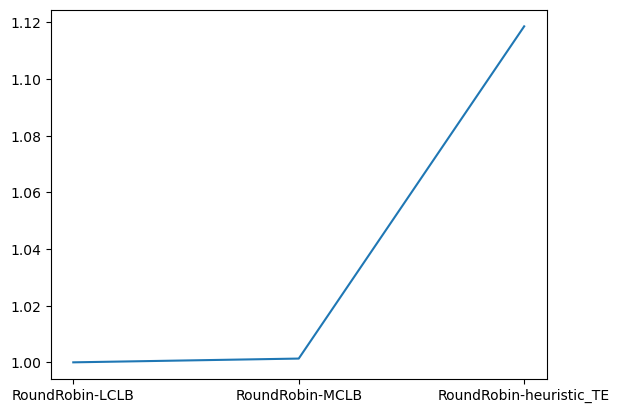

['A0', 'A1', 'B0', 'B1', 'C0', 'C1', 'D0', 'D1', 'E0', 'E1', 'F0', 'F1']


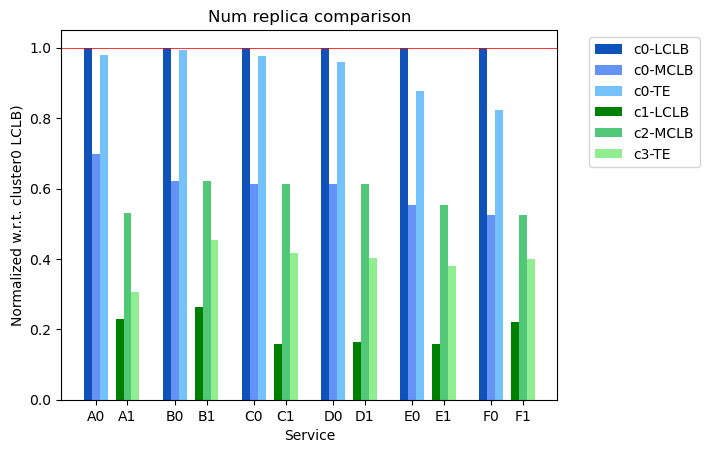

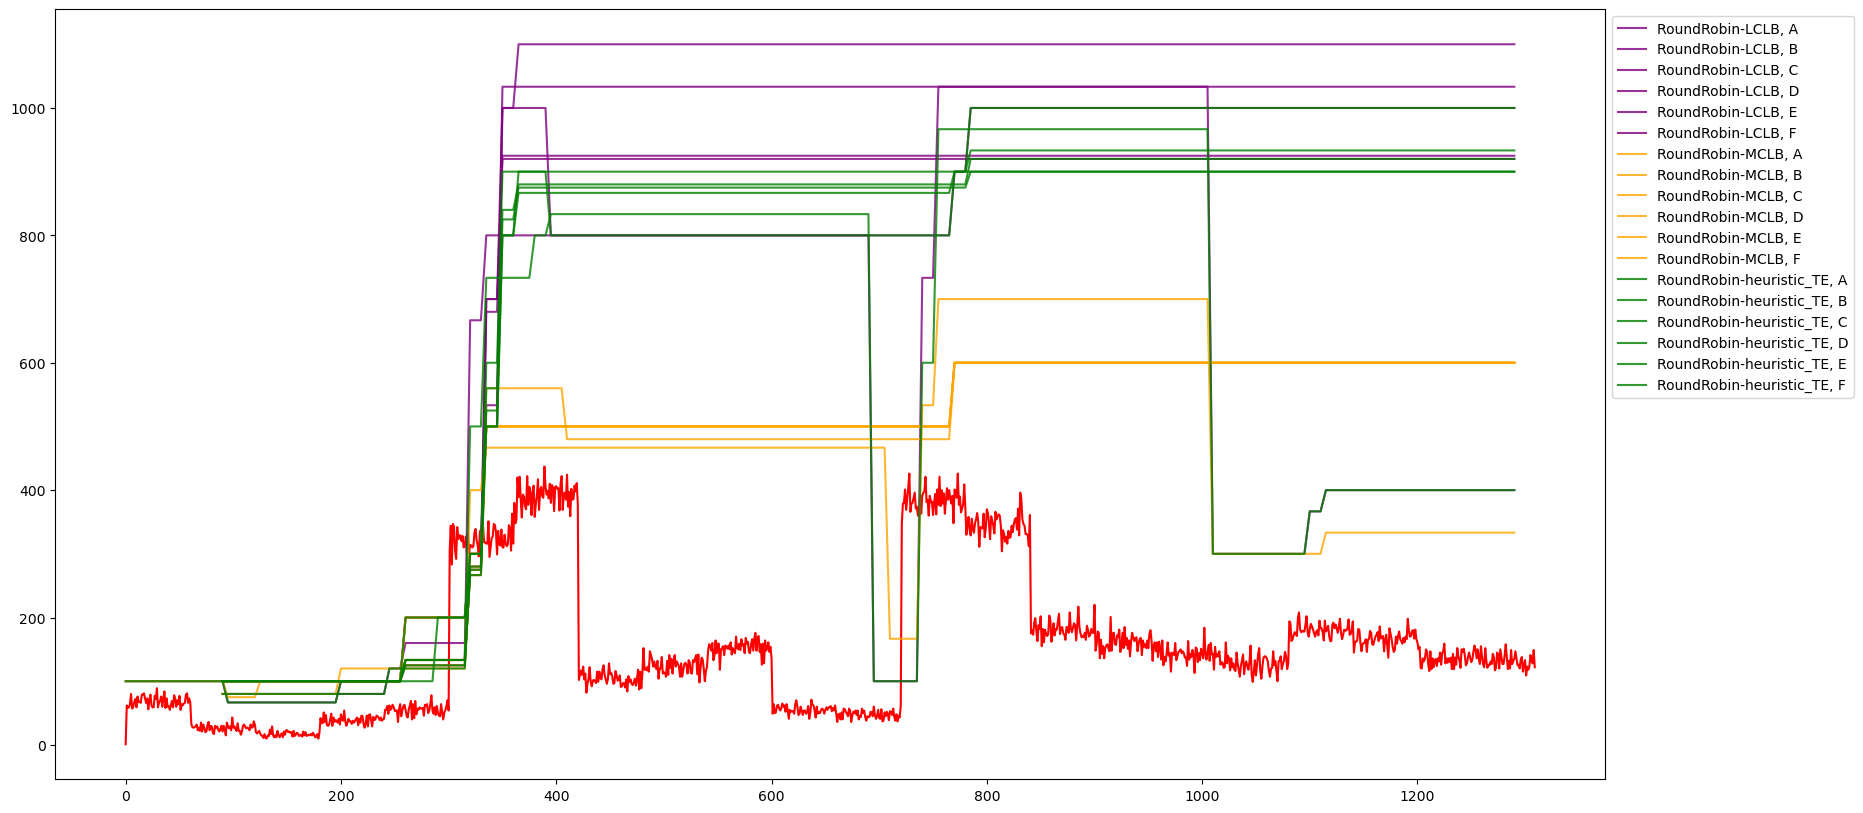

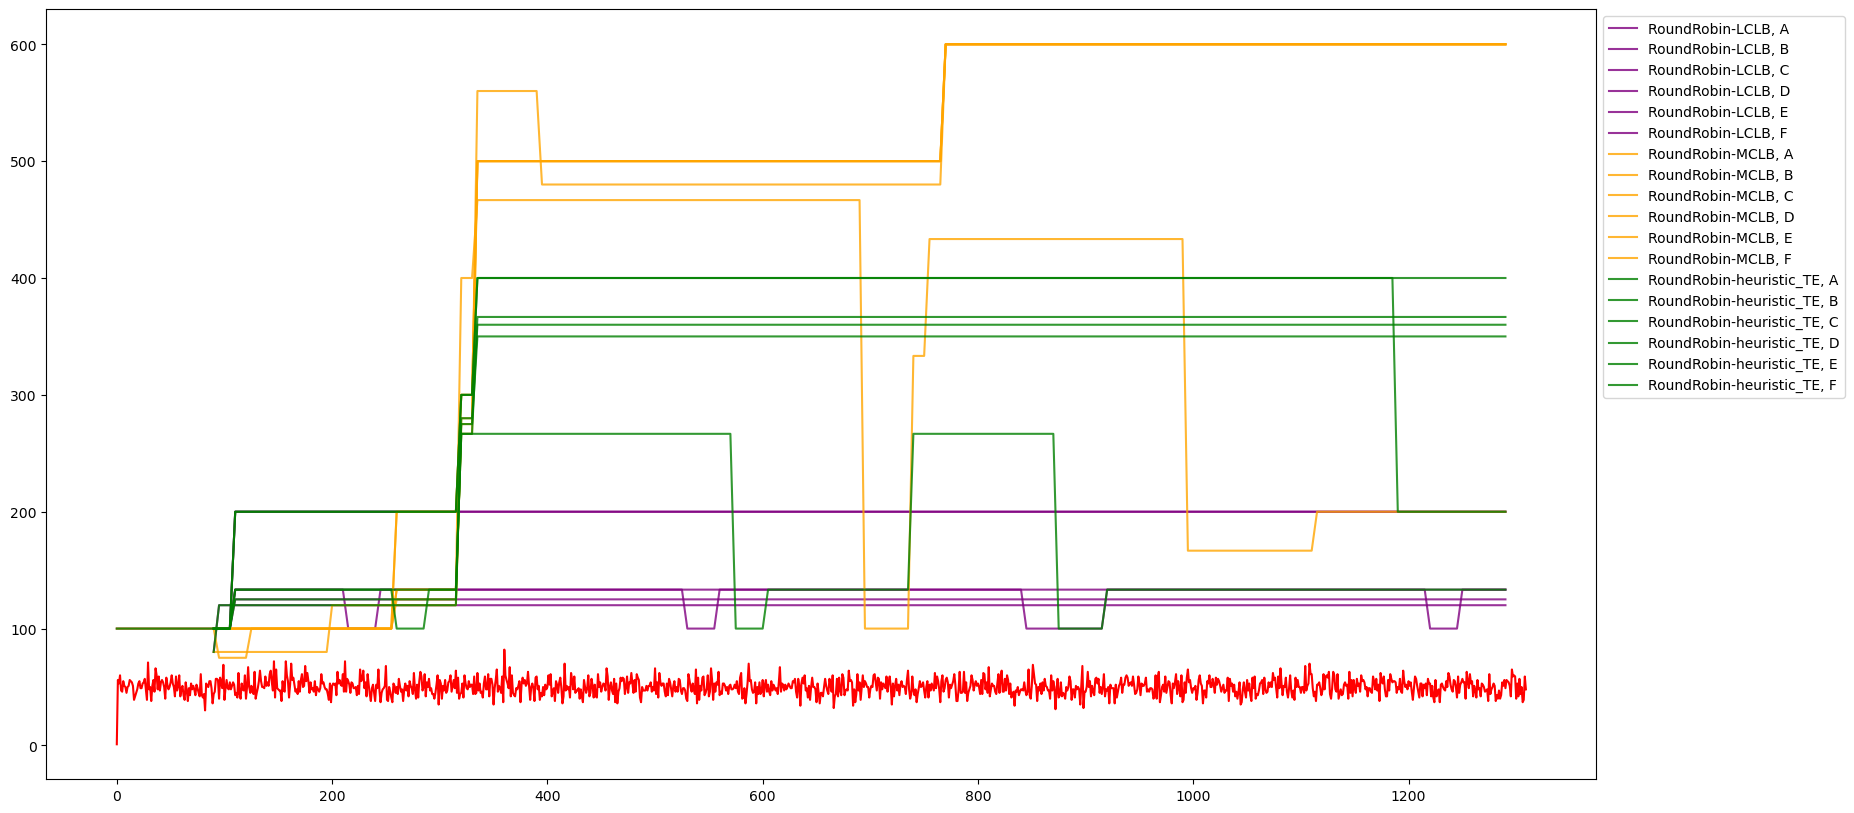

In [7]:
############################################################3
''' Input file '''
path_to_experiment="../simulator/log/sample/three_depth/"
############################################################3

''' Get summary of resource usage '''
files = list()
for routing in routing_algorithm:
    f_ = path_to_experiment + routing + "/resource_provisioing_log.csv"
    files.append(f_)
df_usage, df, svc_list = calc_resource_usage(files)
compare_total_resource_consumption(df_usage)
plot_resource_bar_graph(df_usage)
plot_resource_usage_trend(df)

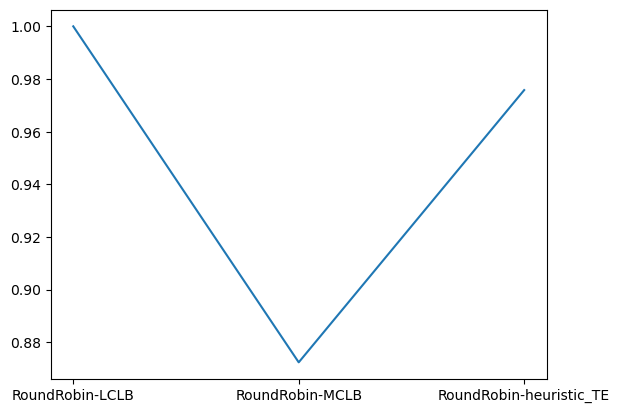

['A0', 'A1', 'B0', 'B1', 'C0', 'C1', 'D0', 'D1', 'E0', 'E1', 'F0', 'F1']


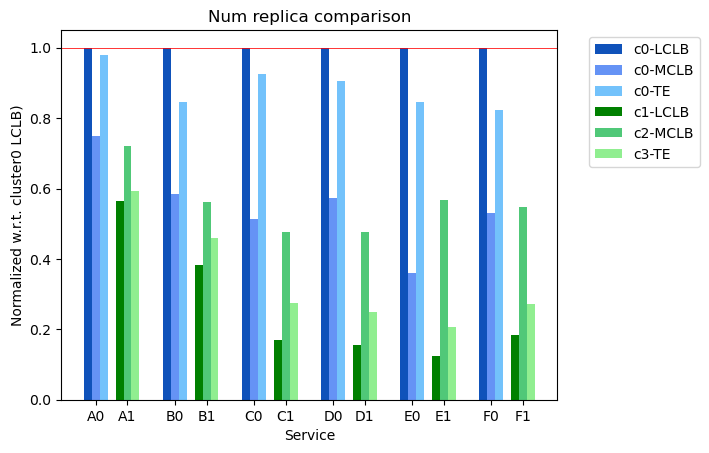

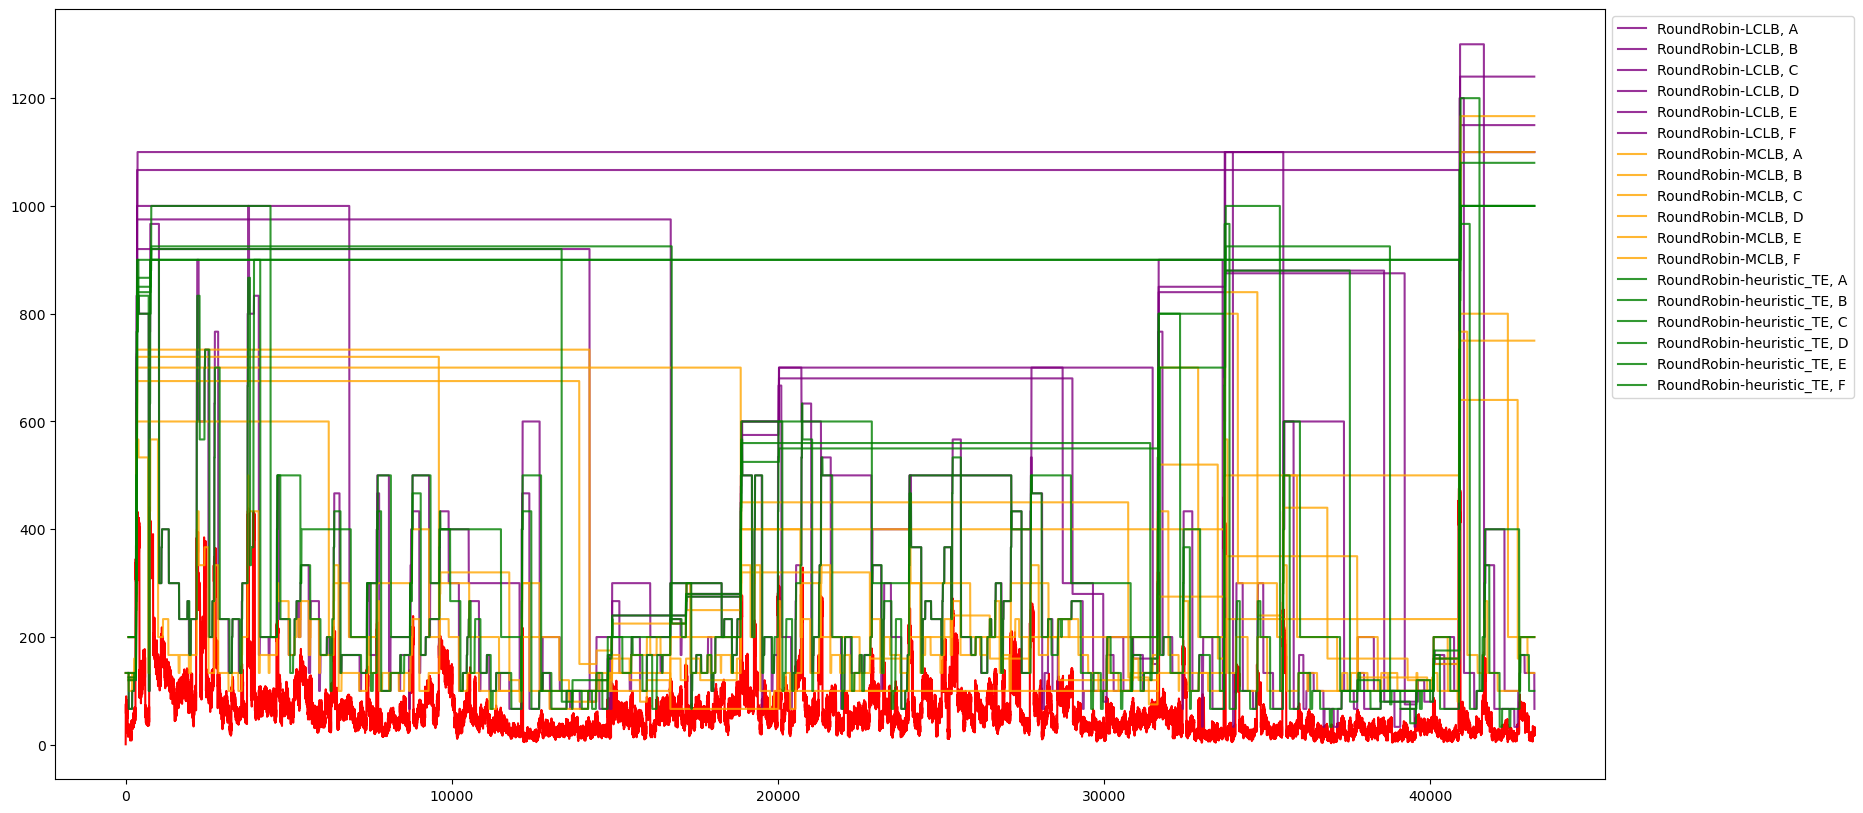

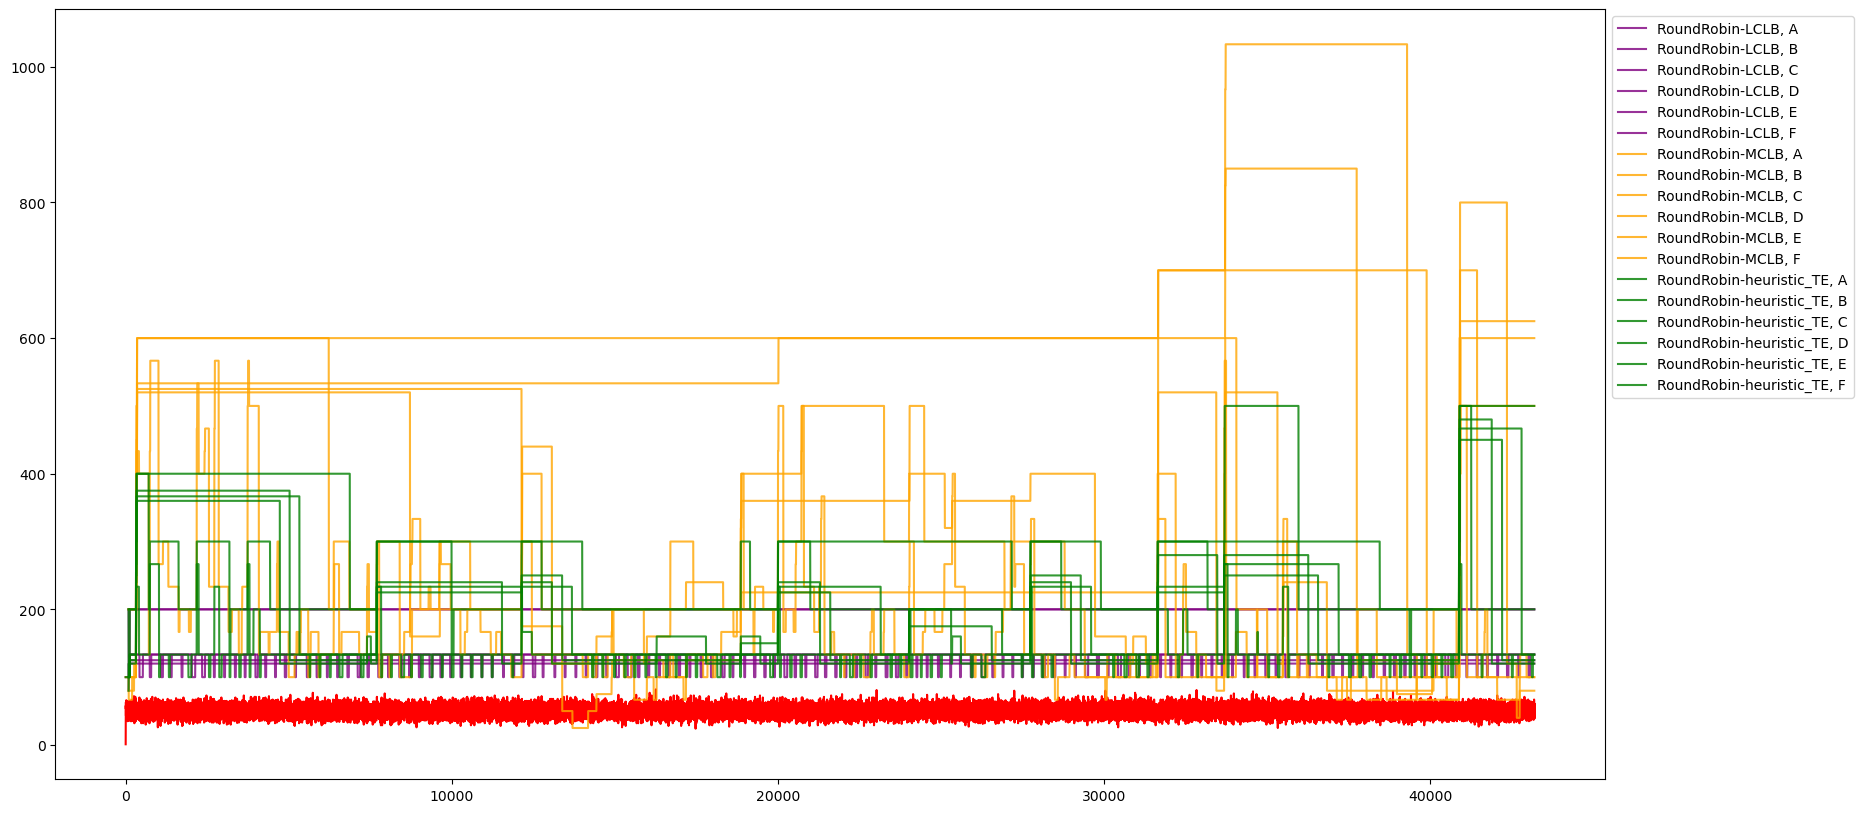

In [9]:
############################################################3
''' Input file '''
path_to_experiment="../simulator/log/6d9c26b9-delay1-auto15000/three_depth/"
############################################################3

''' Get summary of resource usage '''
files = list()
for routing in routing_algorithm:
    f_ = path_to_experiment + routing + "/resource_provisioing_log.csv"
    files.append(f_)
df_usage, df, svc_list = calc_resource_usage(files)
compare_total_resource_consumption(df_usage)
plot_resource_bar_graph(df_usage)
plot_resource_usage_trend(df)

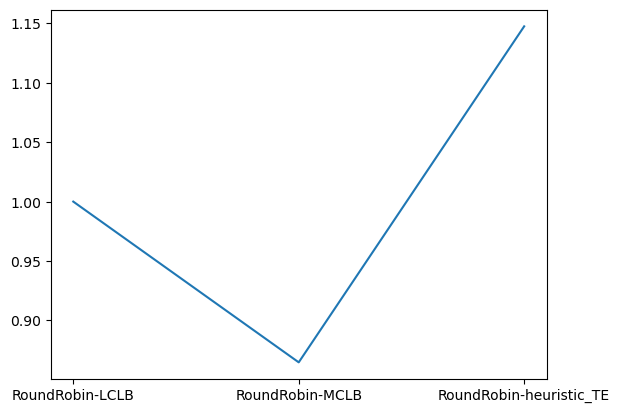

['A0', 'A1', 'B0', 'B1', 'C0', 'C1', 'D0', 'D1', 'E0', 'E1', 'F0', 'F1']


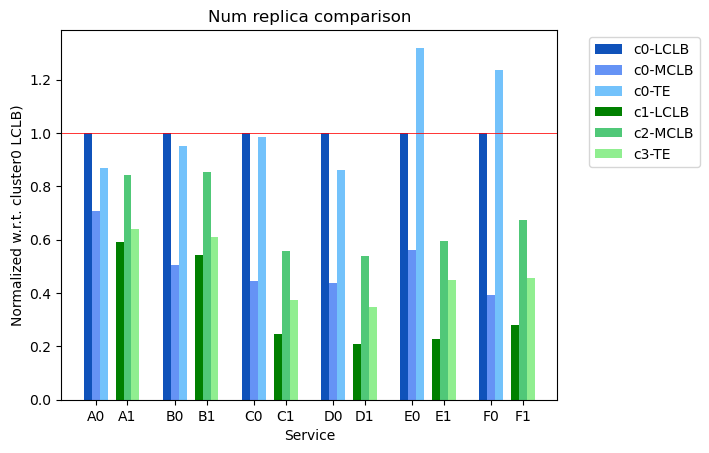

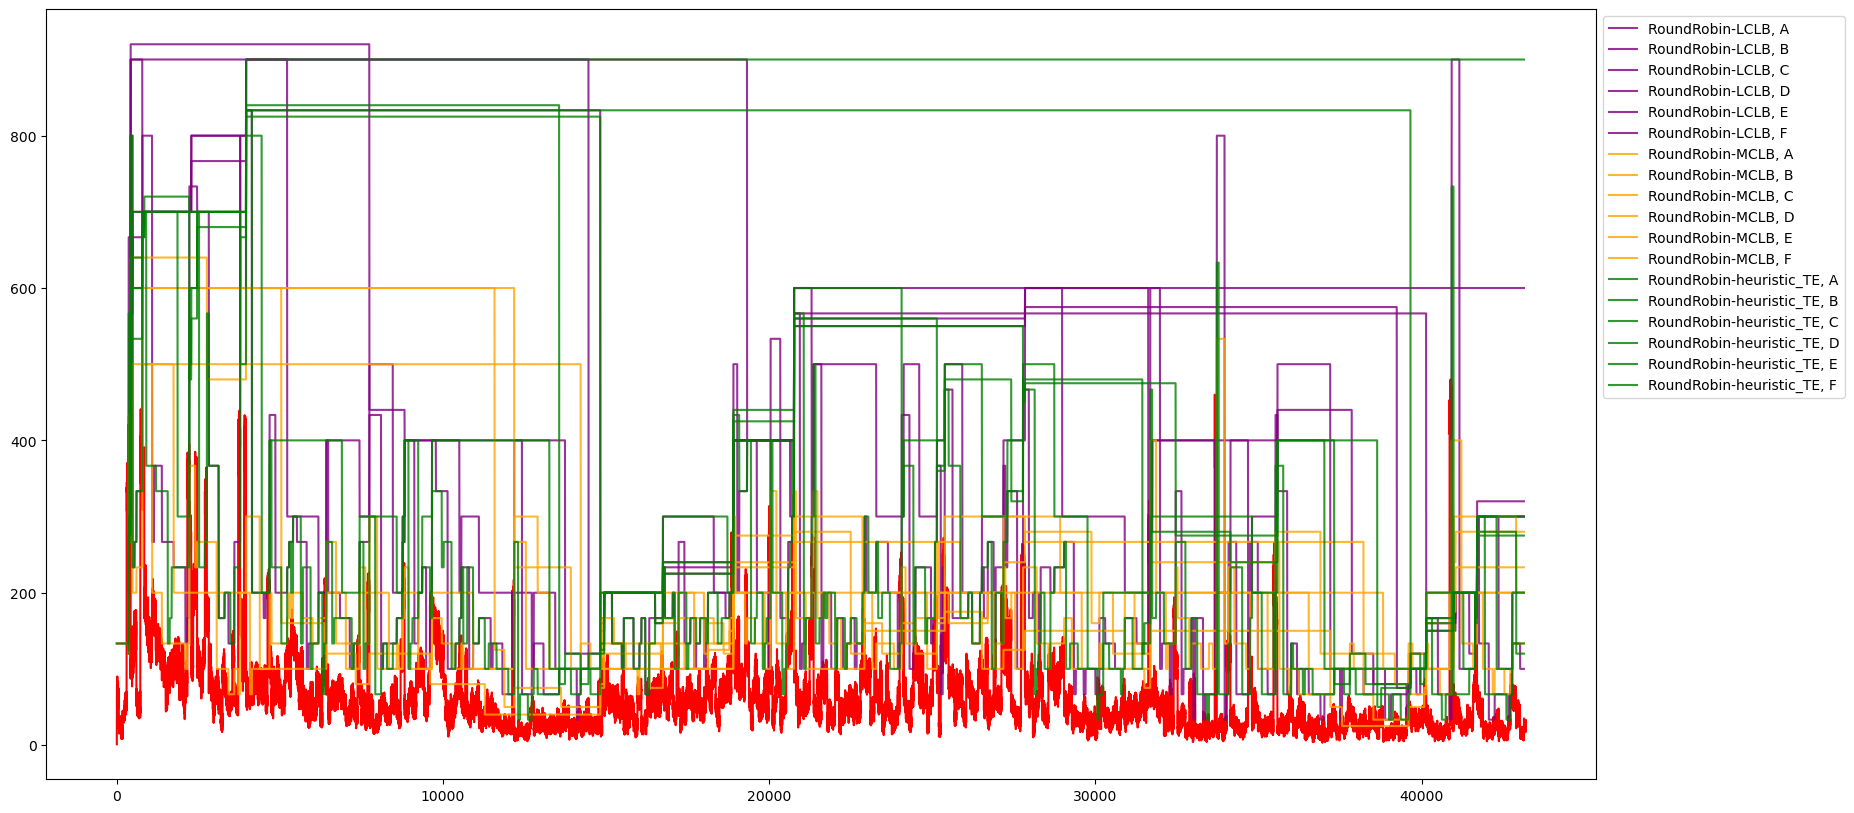

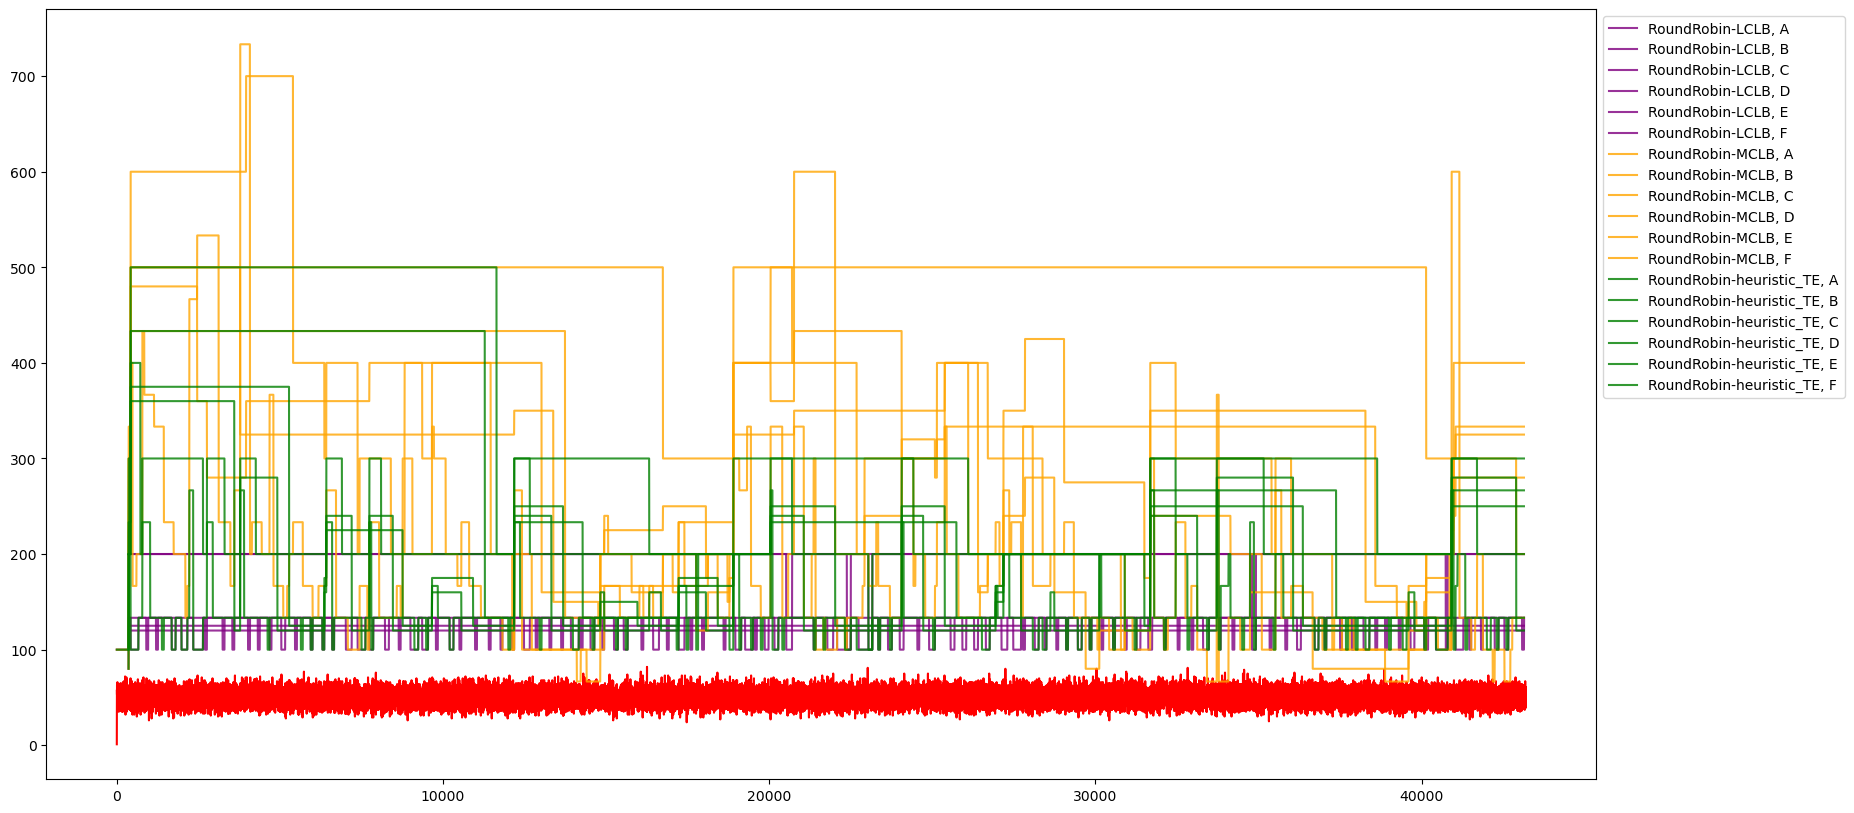

In [10]:
############################################################3
''' Input file '''
path_to_experiment="../simulator/log/6d9c26b9-delay1-auto60000/three_depth/"
############################################################3

''' Get summary of resource usage '''
files = list()
for routing in routing_algorithm:
    f_ = path_to_experiment + routing + "/resource_provisioing_log.csv"
    files.append(f_)
df_usage, df, svc_list = calc_resource_usage(files)
compare_total_resource_consumption(df_usage)
plot_resource_bar_graph(df_usage)
plot_resource_usage_trend(df)

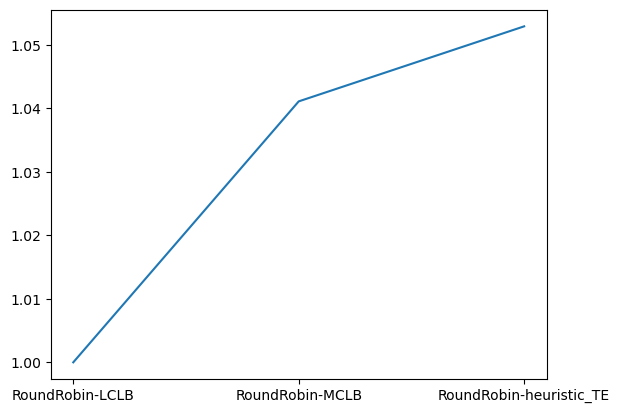

['A0', 'A1', 'B0', 'B1', 'C0', 'C1', 'D0', 'D1', 'E0', 'E1', 'F0', 'F1']


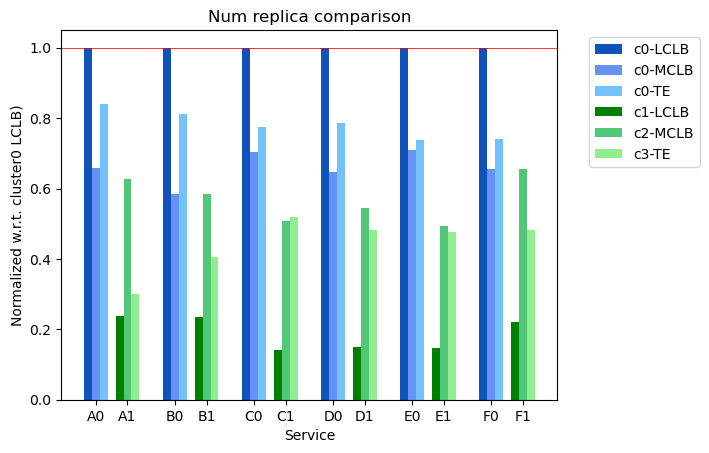

AttributeError: 'Text' object has no property 'step'

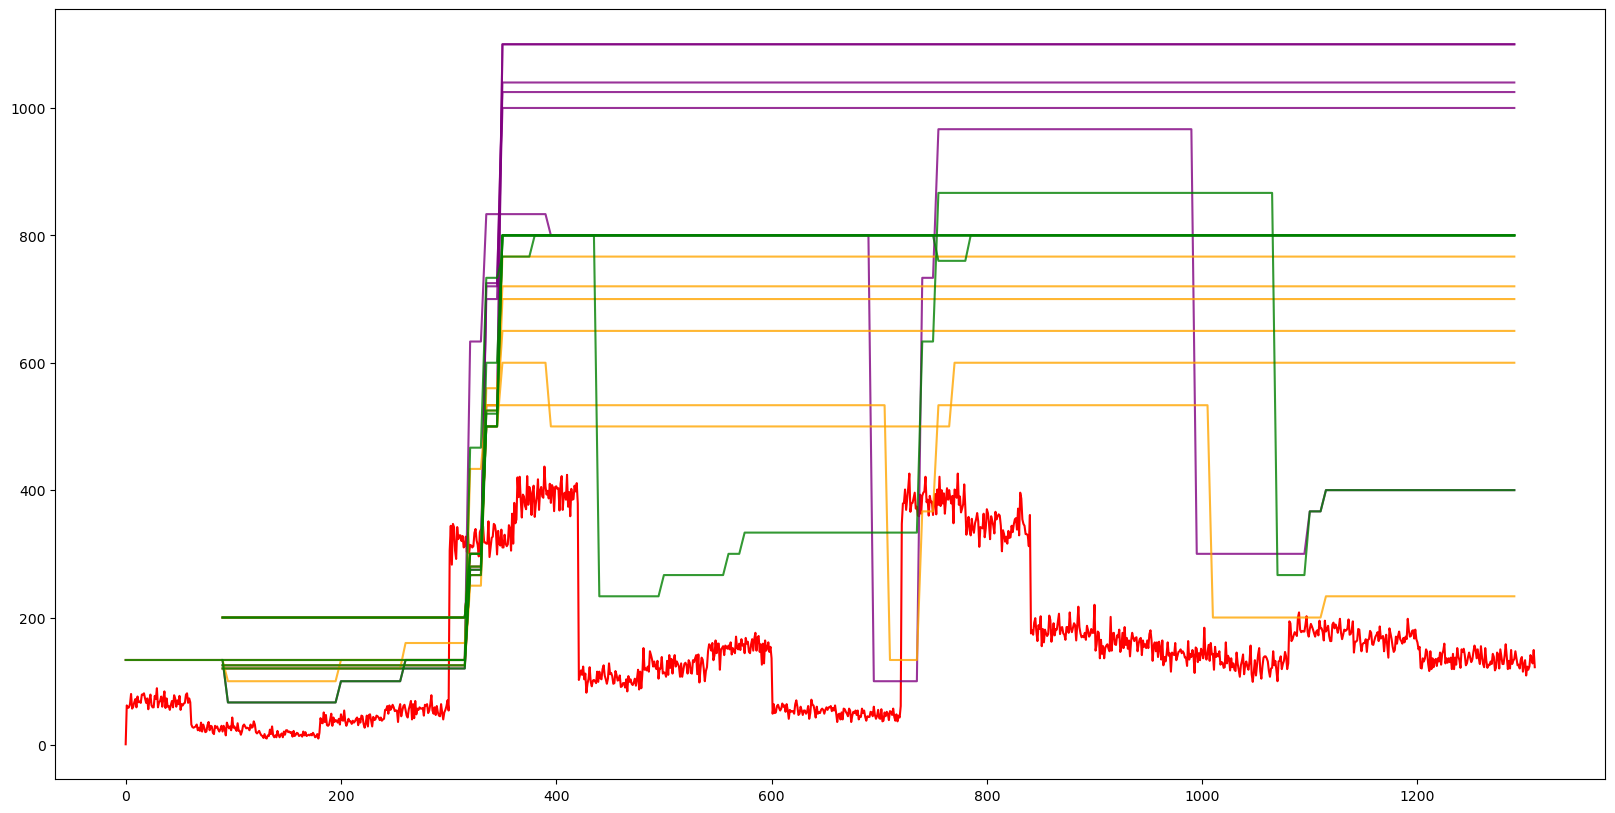

In [14]:
############################################################3
''' Input file '''
path_to_experiment="../simulator/log/sample-opt_te/three_depth/"
############################################################3

''' Get summary of resource usage '''
files = list()
for routing in routing_algorithm:
    f_ = path_to_experiment + routing + "/resource_provisioing_log.csv"
    files.append(f_)
df_usage, df, svc_list = calc_resource_usage(files)
compare_total_resource_consumption(df_usage)
plot_resource_bar_graph(df_usage)
plot_resource_usage_trend(df)